# Project: Face Mask Detection using PyTorch

## Overview

Comparative Study of Residual Networks and Transfer Learning for Object Detection: A Case Study on Face Mask Detection.

## Key Research Questions

* How does a manually implemented ResNet34 differ from a pretrained TorchVision model in feature extraction and convergence?
* What statistical relationships exist between dataset attributes (object sizes, masks, occlusions) and detection accuracy?
* How do strategies like fine-tuning, data augmentation, and loss reweighting affect generalization?

## Credits and Citations

* [SandhyaKrishnan02](https://www.kaggle.com/code/sandhyakrishnan02/face-mask-detection-using-pytorch/notebook)
* https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf

## 1.1 Importing Libraries

In [1]:
# Installations
# Uncomment if running on Kaggle or Colab to install required packages
!pip install xmltodict # for annotations which are in xml format

In [2]:
# System & Utilities
import os
import glob
import xmltodict
import numpy as np
import pandas as pd
from pandas import json_normalize
import xmltodict

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from PIL import Image

# PyTorch Core
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

# TorchVision & Transforms
import torchvision
from torchvision import datasets, transforms, models

# sklear
from sklearn.metrics import classification_report, confusion_matrix

# Misc
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import random

## 1.2 Version Checks

In [3]:
print(f"PyTorch Version: {torch.__version__}")
print(f"TorchVision Version: {torchvision.__version__}")

PyTorch Version: 2.6.0+cu124
TorchVision Version: 0.21.0+cu124


## 1.2 User Variables

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

/kaggle/input
/kaggle/input/face-mask-detection
/kaggle/input/face-mask-detection/annotations
/kaggle/input/face-mask-detection/images


In [5]:
common_path = "/kaggle/input/face-mask-detection/"
xml_path = common_path + "annotations/"
img_path = common_path + "images/"

# 2. EDA

## 2.1 Dataset Overview and Source Audit

Summarize the file sources, dataset origins, structure, and completeness (e.g., annotation-image pair integrity, missing files).

In [6]:
def create_list_of_files(parent_dir='/kaggle/input'):

    total_files = []
    img_files = []
    xml_files = []
    
    for dirname, _, filenames in os.walk(parent_dir):
        for filename in filenames:
            total_files.append(filename) # There are two types of files, .png and .xml
            if filename[-3:]=="png":
                img_files.append(filename)
            elif filename[-3:]=="xml":
                xml_files.append(filename)
            else:
                pass
                
    return total_files, img_files, xml_files

In [7]:
total_files, img_files, xml_files = create_list_of_files()

print(f"Total number of files: {len(total_files)}")
print(f"Number of .img files: {len(img_files)}")
print(f"Number of .xml files: {len(xml_files)}")

Total number of files: 1706
Number of .img files: 853
Number of .xml files: 853


In [8]:
xml_files_only_names = [xml_file[:-4] for xml_file in xml_files]
img_files_only_names = [img_file[:-4] for img_file in img_files]

list(set(xml_files_only_names) - set(img_files_only_names))

[]

### Notes

* There are two types of files:
    * `.xml` files: for annotations, used to store object detection metadata
        * `xmltodict`:
            * python module to make working with xml easy, in the form of `.json`.
            * can unparse it back to `.xml` format  
    * `.png` files: for images, used for training/testing/validations
* There are no unique values present across both the `xml` and `img` lists.

## 2.2 Image Characteristics Analysis

Analyze global image characteristics such as dimensions, aspect ratios, and color depth statistics; report outliers and describe image acquisition diversity.

In [9]:
print(f"Image Path: {img_path} \nXML Path: {xml_path}")

Image Path: /kaggle/input/face-mask-detection/images/ 
XML Path: /kaggle/input/face-mask-detection/annotations/


In [10]:
example_tensor_image = torch.tensor(plt.imread(os.path.join(img_path, "maksssksksss737.png")))
example_tensor_image

tensor([[[0.3765, 0.8235, 0.5882, 0.5569],
         [0.3686, 0.8039, 0.5765, 0.5569],
         [0.3686, 0.7961, 0.5804, 0.5569],
         ...,
         [0.3804, 0.3804, 0.3725, 0.5569],
         [0.3765, 0.3725, 0.3647, 0.5569],
         [0.3373, 0.3373, 0.3294, 0.5569]],

        [[0.3725, 0.8118, 0.5804, 1.0000],
         [0.3725, 0.8078, 0.5804, 1.0000],
         [0.3725, 0.8118, 0.5882, 1.0000],
         ...,
         [0.3843, 0.3843, 0.3765, 1.0000],
         [0.3804, 0.3765, 0.3686, 1.0000],
         [0.3412, 0.3373, 0.3294, 1.0000]],

        [[0.3686, 0.8078, 0.5765, 1.0000],
         [0.3686, 0.8039, 0.5765, 1.0000],
         [0.3765, 0.8157, 0.5882, 1.0000],
         ...,
         [0.3804, 0.3765, 0.3765, 1.0000],
         [0.3686, 0.3647, 0.3647, 1.0000],
         [0.3294, 0.3255, 0.3255, 1.0000]],

        ...,

        [[0.3412, 0.3961, 0.3882, 1.0000],
         [0.1961, 0.2275, 0.2275, 1.0000],
         [0.4000, 0.4196, 0.4275, 1.0000],
         ...,
         [0.2980, 0.2

In [11]:
example_tensor_image.shape

torch.Size([226, 400, 4])

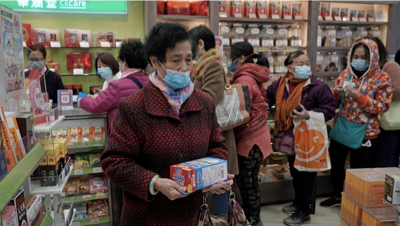

In [12]:
Image.open(os.path.join(img_path, "maksssksksss737.png"))

### Notes

* There are multiple people wearing masks. This means each image can have multiple classes classified -> multiple objects.
* Each object class is represented by a "box"

## 2.3 Annotation Quality and Structure Assessment

Evaluate annotation coverage, format consistency, bounding box completeness, and detect errors or anomalies in annotation files.

In [13]:
def create_metadata_dataframe(xml_files, img_files, common_path="/kaggle/input/face-mask-detection/"):

    xml_path = common_path + "annotations/"
    img_path = common_path + "images/"
    
    df_metadata = pd.DataFrame()

    for xml_file in xml_files:
        xml_file_complete_path = xml_path + xml_file # z.B. /kaggle/input/face-mask-detection/annotations/maksssksksss737.xml
        with open(xml_file_complete_path, 'r', encoding='utf-8') as file:
            metadata = xmltodict.parse(file.read())
        
        # Standardize 'object' as a list
        # If there are multiple "objects" / "people", then each image generates a list of objects
        # Such rows will produce only one column "annotation.object" using json_normalize function
        # Else, it will produce multiple columns if there are only one "object" / "person" in a single image
        
        if "object" in metadata["annotation"] and isinstance(metadata["annotation"]['object'], dict):
            metadata["annotation"]['object'] = [metadata["annotation"]['object']]
            df_t = json_normalize(metadata, record_path=None, meta=['annotation.object'])
        else:
            df_t = json_normalize(metadata)
        
        df_metadata = pd.concat([df_metadata, df_t], ignore_index=True)

    return df_metadata

In [14]:
df_metadata = create_metadata_dataframe(xml_files, img_files)

In [15]:
df_metadata.head(2)

,annotation.folder,annotation.filename,annotation.size.width,annotation.size.height,annotation.size.depth,annotation.segmented,annotation.object
0,images,maksssksksss737.png,400,226,3,0,"[{'name': 'with_mask', 'pose': 'Unspecified', ..."
1,images,maksssksksss410.png,400,267,3,0,"[{'name': 'with_mask', 'pose': 'Unspecified', ..."


Now, there is only one `annotation.object` column even if the row has only one image.

## 2.4 Class Label Analysis

Examine the taxonomy of target classes (e.g., "with_mask," "without_mask," "mask_weared_incorrect"), describe the annotation logic, and discuss potential ambiguities in labeling.

In [16]:
target_classes = []

for annotation_object in df_metadata["annotation.object"]:
    for i in range(len(annotation_object)):
        target_classes.append(annotation_object[i]["name"])

len(target_classes)

4072

In [17]:
target_items = Counter(target_classes).keys()
target_values = Counter(target_classes).values()

for i,j in zip(target_items, target_values):
    print(f"{i}: {j}")

with_mask: 3232
mask_weared_incorrect: 123
without_mask: 717


### Notes:

* There are three target classes
* `with_mask`, `mask_weared_incorrect`, `without_mask`
* Should I rectify the dataset's `weared` to `worn` ? No. I don't want to f up my results for now.

## 2.5 Target Class Distribution and Imbalance Visualization

Present quantitative class frequencies, visual summaries (bar, pie charts), and compute class imbalance metrics. Discuss the implications of any observed imbalance on downstream modeling.

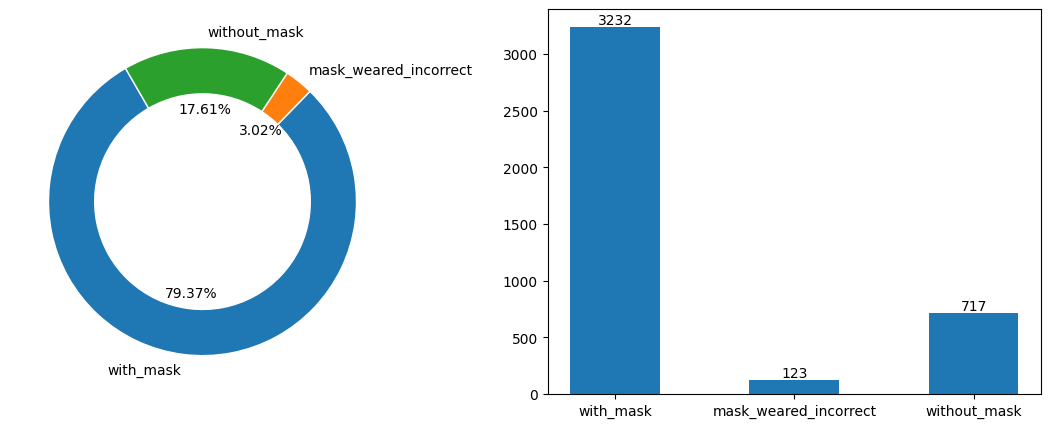

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5)) # 1 row, 2 columns, 14 inches wide, 5 inches tall

# Pie Chart
## wedgeprops=dict(width=0.3, edgecolor="w"): Draws slices as donut wedges with width 0.3 of the radius and white edges between wedges.
## radius=1: Radius of the pie chart (default is 1).
## startangle=120: Rotates the start of the pie chart by 120 degrees counterclockwise, so wedges start at that angle.
## autopct='%1.2f%%': Formats and displays the percentage value inside each wedge with 2 decimal places.

ax1.pie(target_values, 
        wedgeprops=dict(width=0.3, edgecolor="w"), 
        labels=target_items, 
        radius=1, 
        startangle=120, 
        autopct='%1.2f%%')

# Bar Chart
## width=0.5: width of the bar
## bar_label: add labels to the chart

bars = ax2.bar(target_items,
             list(target_values),
             width=0.5)
ax2.bar_label(bars) # add value to bar chart

plt.show()

### Notes

* There are three target classes
* Each class can be given a specific color to cascade the face
    * Red: without mask
    * Yellow: with mask, but worn incorrectly
    * Green: with mask

# 3. Image and Annotation Mapping

Detail the process of associating image files with their annotation files. Explain how images are parsed, and how bounding boxes and class labels are extracted from metadata.

## 3.1 Functional Utilities for Dataset Parsing

Here, consolidate all data-handling scripts, such as file listing, metadata creation, and key helper routines. Place all functions here—maintain this early in the notebook or as a separate .py file/module for import so the main workflow is streamlined.

In [19]:
def face_cascade(img_name, df_metadata, common_path="/kaggle/input/face-mask-detection/"):

    img_path = os.path.join(common_path, "images")
    xml_path = os.path.join(common_path, "annotations")
    
    img = plt.imread(os.path.join(img_path, img_name))
    fig, ax = plt.subplots(1)
    ax.axis("off")
    fig.set_size_inches(10, 5)
    ax.imshow(img)

    metadata_row = df_metadata[df_metadata["annotation.filename"] == img_name] # Filter metadata for just the current image
    
    if not metadata_row.empty:
        annotation_list = metadata_row.iloc[0]["annotation.object"]
        if isinstance(annotation_list, dict):
            annotation_list = [annotation_list]
        for obj in annotation_list:
            x, y, xmax, ymax = list(map(int, obj["bndbox"].values()))
            width, height = xmax - x, ymax - y
            if obj["name"] == "with_mask":
                edge_color, annotation_color, annotation_text = "g", "green", "with_mask"
            elif obj["name"] == "without_mask":
                edge_color, annotation_color, annotation_text = "r", "red", "without_mask"
            else:
                edge_color, annotation_color, annotation_text = "y", "yellow", "mask_weared_incorrect"
            mpatch = mpatches.Rectangle((x, y), width, height, linewidth=2, edgecolor=edge_color, facecolor="none")
            ax.add_patch(mpatch)
            rx, ry = mpatch.get_xy()
            ax.annotate(annotation_text, (rx, ry), color=annotation_color, weight='bold', fontsize=10, ha='left', va='baseline')

In [20]:
def create_tensor_dataset(img_files, df_metadata, common_path="/kaggle/input/face-mask-detection/"):

    img_path = os.path.join(common_path, "images")
    image_tensor = []
    label_tensor = []

    my_transform = transforms.Compose([transforms.Resize((226, 226)), transforms.ToTensor()])
    options = {"with_mask": 0, "without_mask": 1, "mask_weared_incorrect": 2}

    for img_name in img_files:
        metadata_row = df_metadata[df_metadata["annotation.filename"] == img_name]
        if not metadata_row.empty:
            annotation_list = metadata_row.iloc[0]["annotation.object"]
            if isinstance(annotation_list, dict):
                annotation_list = [annotation_list]
            for obj in annotation_list:
                xmin, ymin, xmax, ymax = list(map(int, obj["bndbox"].values()))
                width = xmax - xmin
                height = ymax - ymin
                label = options[obj["name"]]
                with Image.open(os.path.join(img_path, img_name)).convert("RGB") as im:
                    cropped_image = transforms.functional.crop(im, ymin, xmin, height, width)
                    image_tensor.append(my_transform(cropped_image))
                    label_tensor.append(torch.tensor(label))
    return image_tensor, label_tensor

### Notes

* `torchvision.transforms.Compose()`: torchvision.transforms is used for common image transformations and when Compose is chained with it to Compose several transforms together.
* `transforms.Resize()`: The default interpolation is InterpolationMode.BILINEAR. It resize the input image as per the height and width provided.
* `transforms.functional.crop()`: Crop the given image at specified location and output size and it returs torch.Tensor.

## 3.2 Visual Verification: Annotated Image Display

Present functions/cells that visualize images with bounding box overlays and class-specific color coding. This step lets you audit if parsing and mapping from annotation to image is working, and spot label errors or ambiguities.

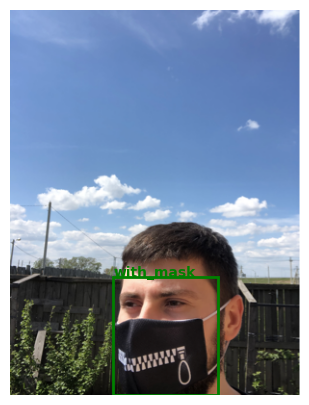

In [21]:
test_images = img_files[:1]
for img in test_images:
   face_cascade(img, df_metadata)

In [22]:
test_images = img_files[:]
test_image_tensor, test_label_tensor = create_tensor_dataset(test_images, df_metadata)

In [23]:
print(f"Length of image tensor: {len(test_image_tensor)}")
print(f"Length of label tensor: {len(test_label_tensor)}")

print(f"Shape of image tensor: {test_image_tensor[0].shape}")

Length of image tensor: 4072
Length of label tensor: 4072
Shape of image tensor: torch.Size([3, 226, 226])


## 3.4 Dataset Preparation and Train-Test Split

Systematically generate your training, validation, and test sets, ensuring class distribution and stratification. Document the balance, random seed setting, and structure of produced datasets.

In [24]:
train_size = int(len(test_image_tensor)*0.7)
test_size = len(test_image_tensor)-train_size

print(f"Training data size: {train_size}")
print(f"Testing data size: {test_size}")

Training data size: 2850
Testing data size: 1222


In [25]:
test_complete_dataset = [[img, lbl] for img,lbl in zip(test_image_tensor, test_label_tensor)]

In [26]:
trainset,testset = torch.utils.data.random_split(test_complete_dataset,[train_size, test_size])

## 3.5 DataLoader and Batch Inspection

Instantiate PyTorch DataLoader objects and visualize sample batches. Here, check both data shapes and visual samples to ensure correct batching and labelling for training.

In [27]:
train_dataloader = DataLoader(dataset=trainset, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = DataLoader(dataset=testset, batch_size=32, shuffle=True, num_workers=4)

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 226, 226])
Labels batch shape: torch.Size([32])


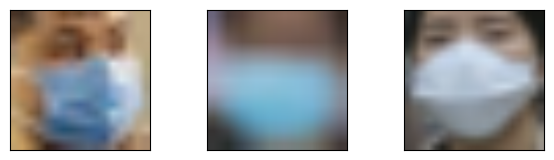

In [30]:
warnings.filterwarnings("ignore", category=UserWarning)
    
train_features_np=train_features.numpy()

fig=plt.figure(figsize=(25,4))
for idx in np.arange(3):
    ax=fig.add_subplot(2,20//2,idx+1,xticks=[],yticks=[])
    plt.imshow(np.transpose(train_features_np[idx],(1,2,0)))

# 4. Model Development and Architecture Analysis

## 4.1 Implementation of ResNet34 Architecture

In [31]:
target_items

dict_keys(['with_mask', 'mask_weared_incorrect', 'without_mask'])

In [32]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet34(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet34, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 3)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [33]:
# Manual Model

manual_model = ResNet34(num_classes=len(target_items))

In [34]:
# torchvision

torchvision_model = models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 180MB/s]


## 4.2 Feature Extraction Workflow

Detail how features are extracted at various network depths, including early convolutional layers, residual blocks, and final fully connected representations. Visualize sample feature maps or activations.

In [35]:
# Manual Model

for param in manual_model.parameters():
    param.requires_grad=False

In [36]:
#torchvision

for param in torchvision_model.parameters():
    param.requires_grad=False

## 4.3 Model Layer Composition and Operational Details

Explain each major model component—convolutional layers, batch normalization, skip connections, linear layers—using both code and diagrams. Include basic statistics: parameter count, layer shapes, and function docstrings.

In [37]:
# Manual Model

manual_model

ResNet34(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [38]:
# torchvision

torchvision_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 4.4 Mathematical Underpinning of Linear Transformations

Present the formulae and code for computing linear transformations, including how input dimensions relate to output for dense and convolutional operations.

In [39]:
# Manual Model

n_inputs = manual_model.fc.in_features
last_layer=nn.Linear(n_inputs,3)

manual_model.fc.out_features=last_layer
manual_model.fc = last_layer # This correctly places the new trainable layer in the model.
print('reinitialize model with output features as 3 :', manual_model.fc.out_features)

features_resnet34 = []
for key,value in manual_model._modules.items():
    features_resnet34.append(value)

print(f"Features of Torchvision Resnet34: {features_resnet34}")

reinitialize model with output features as 3 : 3
Features of Torchvision Resnet34: [Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (1): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [40]:
# torchvision

n_inputs = torchvision_model.fc.in_features
last_layer=nn.Linear(n_inputs,3)

# torchvision_model.fc.out_features=last_layer
torchvision_model.fc = last_layer # This correctly places the new trainable layer in the model.
print('reinitialize model with output features as 3 :', torchvision_model.fc.out_features)

features_resnet34 = []
for key,value in torchvision_model._modules.items():
    features_resnet34.append(value)

print(f"Features of Torchvision Resnet34: {features_resnet34}")

reinitialize model with output features as 3 : 3
Features of Torchvision Resnet34: [Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)

## 4.5 Analytical Calculation of Convolutional Layer Parameters

Describe how each layer’s parameter count is derived, along with input/output dimension calculation for convolutions (formula, code example, summary table for the network).

In [41]:
def get_conv_layer_parameters_details(model):
    conv_layer = model.layer2[0].conv1
    in_channels = conv_layer.in_channels
    out_channels = conv_layer.out_channels
    kernel_size = conv_layer.kernel_size
    stride = conv_layer.stride
    padding = conv_layer.padding

    return conv_layer, in_channels, out_channels, kernel_size, stride, padding

In [42]:
# Manual Model

conv_layer, in_channels, out_channels, kernel_size, stride, padding = get_conv_layer_parameters_details(manual_model)

print(f"Convolution Layer: {conv_layer}")
print(f"In channels: {in_channels}")
print(f"Out channels: {out_channels}")
print(f"Kernel Size: {kernel_size}")
print(f"Stride: {stride}")
print(f"Padding: {padding}")

conv_param = in_channels * out_channels * kernel_size[0] * kernel_size[1]
print(f"Number of Parameters for conv2D is: {conv_param}")

Convolution Layer: Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
In channels: 64
Out channels: 128
Kernel Size: (3, 3)
Stride: (2, 2)
Padding: (1, 1)
Number of Parameters for conv2D is: 73728


In [43]:
# torchvision

conv_layer, in_channels, out_channels, kernel_size, stride, padding = get_conv_layer_parameters_details(torchvision_model)

print(f"Convolution Layer: {conv_layer}")
print(f"In channels: {in_channels}")
print(f"Out channels: {out_channels}")
print(f"Kernel Size: {kernel_size}")
print(f"Stride: {stride}")
print(f"Padding: {padding}")

conv_param = in_channels * out_channels * kernel_size[0] * kernel_size[1]
print(f"Number of Parameters for conv2D is: {conv_param}")

Convolution Layer: Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
In channels: 64
Out channels: 128
Kernel Size: (3, 3)
Stride: (2, 2)
Padding: (1, 1)
Number of Parameters for conv2D is: 73728


# 5. Training and Performance Evaluation

## 5.1 Model Training Procedure

Implementing the epoch-wise training loop, define optimizers, learning rate schedule, and batch management. Record training and validation performance at each step.

In [44]:
def train_model(model, num_epochs, train_dataloader, test_dataloader, device='cuda'):
    
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import pandas as pd

    # Freeze early layers
    ct = 0
    for child in model.children():
        ct += 1
        if ct < 7:
            for param in child.parameters():
                param.requires_grad = False

    print("Frozen layers up to index:", ct)

    if torch.cuda.is_available():
        model.to(device)
        print("Training on:", device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)

    df_final = pd.DataFrame(columns=["epoch", "avg_batch_loss", "training_loss", "test_loss", "test_acc"])
    
    test_true_labels = []
    test_pred_labels = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_losses = []

        for i, (inputs, labels) in enumerate(train_dataloader):
            if torch.cuda.is_available():
                inputs , labels = inputs.cuda(), labels.cuda()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_losses.append(loss.item())

            if (i + 1) % 20 == 0:
                avg_batch_loss = running_loss / 20
                print(f"Epoch {epoch+1}, Batch {i+1}, Avg Batch Loss: {avg_batch_loss}")
                running_loss = 0.0  # Reset running_loss after logging avg for batches

        # ----- Evaluate on test dataset after epoch -----
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        # Clear lists each epoch to accumulate fresh epoch-level predictions or move this outside if desired overall collection
        test_true_labels.clear()
        test_pred_labels.clear()

        with torch.no_grad():
            for test_inputs, test_labels in test_dataloader:
                if torch.cuda.is_available():
                    test_inputs, test_labels = test_inputs.cuda(), test_labels.cuda()

                outputs = model(test_inputs)
                loss = criterion(outputs, test_labels)
                test_loss += loss.item()

                _, predicted = outputs.max(1)
                total += test_labels.size(0)
                correct += (predicted == test_labels).sum().item()

                # Collect labels and predictions for later analysis
                test_true_labels.append(test_labels.cpu().numpy())
                test_pred_labels.append(predicted.cpu().numpy())

        avg_test_loss = test_loss / len(test_dataloader)
        test_acc = correct / total
        avg_train_loss = sum(train_losses) / len(train_losses)

        df_final.loc[epoch] = [epoch+1, avg_batch_loss, avg_train_loss, avg_test_loss, test_acc]

    print("Finished Training")    
    return df_final, test_true_labels, test_pred_labels

In [45]:
df_manual_model_training, test_true_labels_manual, test_pred_labels_manual = train_model(manual_model, 3, train_dataloader, test_dataloader)

Frozen layers up to index: 8
Epoch 1, Batch 20, Avg Batch Loss: 0.7067869633436203
Epoch 1, Batch 40, Avg Batch Loss: 0.6231665521860122
Epoch 1, Batch 60, Avg Batch Loss: 0.6189930573105812
Epoch 1, Batch 80, Avg Batch Loss: 0.547487185895443
Epoch 2, Batch 20, Avg Batch Loss: 0.5783079832792282
Epoch 2, Batch 40, Avg Batch Loss: 0.5714763164520263
Epoch 2, Batch 60, Avg Batch Loss: 0.6136540532112121
Epoch 2, Batch 80, Avg Batch Loss: 0.5411639109253883
Epoch 3, Batch 20, Avg Batch Loss: 0.5871397882699967
Epoch 3, Batch 40, Avg Batch Loss: 0.5142442256212234
Epoch 3, Batch 60, Avg Batch Loss: 0.5305416315793992
Epoch 3, Batch 80, Avg Batch Loss: 0.5401937380433083
Finished Training


In [46]:
df_torchvision_model_training, test_true_labels_torchvision, test_pred_labels_torchvision = train_model(torchvision_model, 3, train_dataloader, test_dataloader)

Frozen layers up to index: 10
Epoch 1, Batch 20, Avg Batch Loss: 0.7514751479029655
Epoch 1, Batch 40, Avg Batch Loss: 0.5107320889830589
Epoch 1, Batch 60, Avg Batch Loss: 0.39911263063549995
Epoch 1, Batch 80, Avg Batch Loss: 0.3914713189005852
Epoch 2, Batch 20, Avg Batch Loss: 0.3823172315955162
Epoch 2, Batch 40, Avg Batch Loss: 0.38077707067131994
Epoch 2, Batch 60, Avg Batch Loss: 0.2986332580447197
Epoch 2, Batch 80, Avg Batch Loss: 0.32836263105273245
Epoch 3, Batch 20, Avg Batch Loss: 0.30740575343370435
Epoch 3, Batch 40, Avg Batch Loss: 0.29881419874727727
Epoch 3, Batch 60, Avg Batch Loss: 0.3070989727973938
Epoch 3, Batch 80, Avg Batch Loss: 0.30826680138707163
Finished Training


## 5.2 Loss Curve Analysis and Model Convergence

Visualize training and validation loss curves, with statistical summaries. Analyze overfitting/underfitting risks, minimum loss achieved, epoch-by-epoch learning quality.

In [47]:
def plot_loss(df_final, kind='batch'):
    """
    Plots training loss from df_final DataFrame.

    Args:
        df_final (pd.DataFrame): DataFrame containing 'epoch', 'batch', 'avg_batch_loss'.
        kind (str): 'batch' to plot loss vs. batch (within or across epochs),
                    'epoch' to plot average loss per epoch.
    """
    if kind == 'batch':
        # Plot avg_batch_loss over all reported batches
        plt.figure(figsize=(10, 5))
        plt.plot(df_final.index, df_final['avg_batch_loss'], label='Avg Batch Loss')
        plt.xlabel('Logged Batch Index')
        plt.ylabel('Avg Batch Loss')
        plt.title('Average Batch Loss Over Training')
        plt.legend()
        plt.show()
    elif kind == 'epoch':
        # Compute the average loss for each epoch
        epoch_loss = df_final.groupby('epoch')['avg_batch_loss'].mean()
        plt.figure(figsize=(8, 4))
        plt.plot(epoch_loss.index, epoch_loss.values, marker='o', label='Avg Epoch Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Avg Batch Loss')
        plt.title('Mean Average Batch Loss Per Epoch')
        plt.legend()
        plt.show()
    else:
        print("Invalid kind specified: use 'batch' or 'epoch'.")

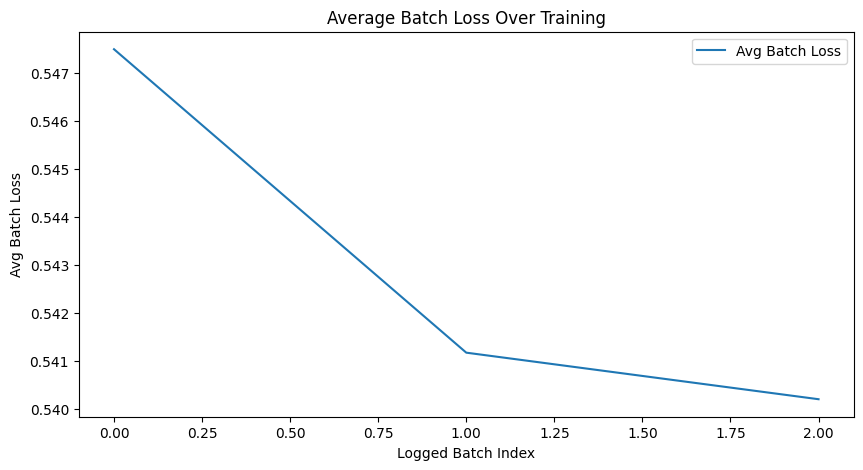

In [48]:
# Manual Model

plot_loss(df_manual_model_training, kind='batch')

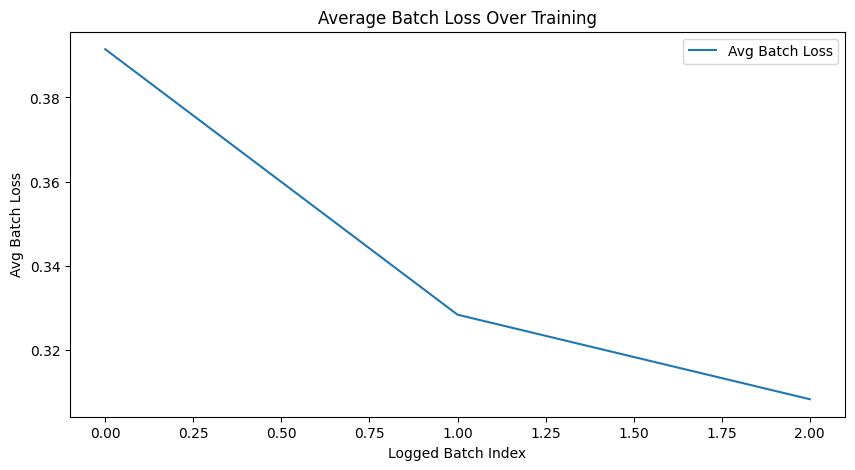

In [49]:
# torchvision

plot_loss(df_torchvision_model_training, kind='batch')

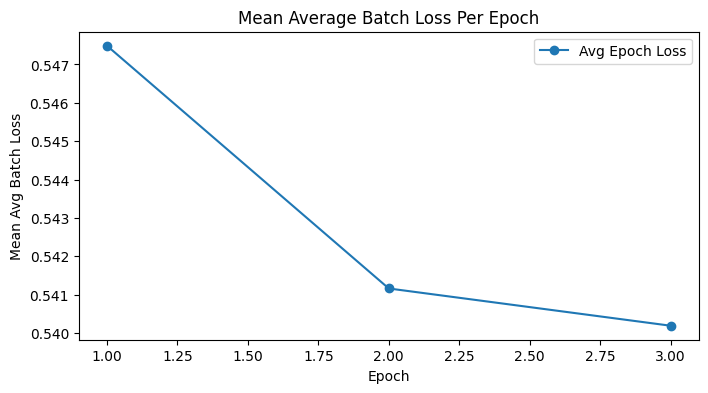

In [50]:
# Manual Model

plot_loss(df_manual_model_training, kind='epoch')

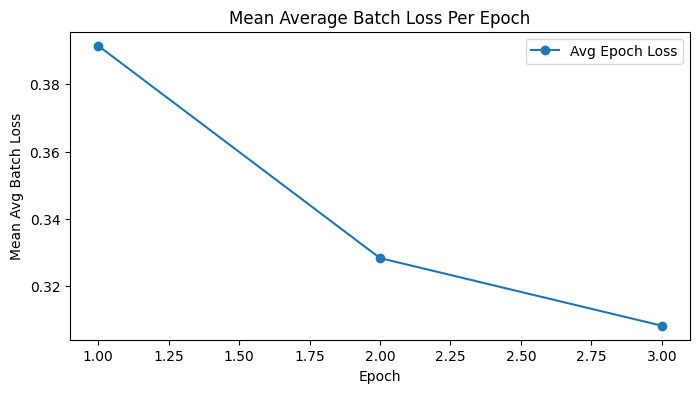

In [51]:
# torchvision

plot_loss(df_torchvision_model_training, kind='epoch')

## 5.3 Accuracy and Metric Evaluation

Present classification metrics—accuracy, precision, recall, F1-score—at epoch level and for final model performance. Compute confusion matrices and detailed per-class statistics.

In [52]:
def accuracy_metric_evaluation(test_true_labels, test_pred_labels, class_names):
    # Assuming test_true_labels and test_pred_labels are lists of numpy arrays collected during testing
    y_true = np.concatenate(test_true_labels)
    y_pred = np.concatenate(test_pred_labels)
    
    # Classification report with detailed metrics per class
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Confusion matrix visualization
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

                       precision    recall  f1-score   support

            with_mask       0.80      1.00      0.89       975
mask_weared_incorrect       0.00      0.00      0.00       216
         without_mask       0.00      0.00      0.00        31

             accuracy                           0.80      1222
            macro avg       0.27      0.33      0.30      1222
         weighted avg       0.64      0.80      0.71      1222



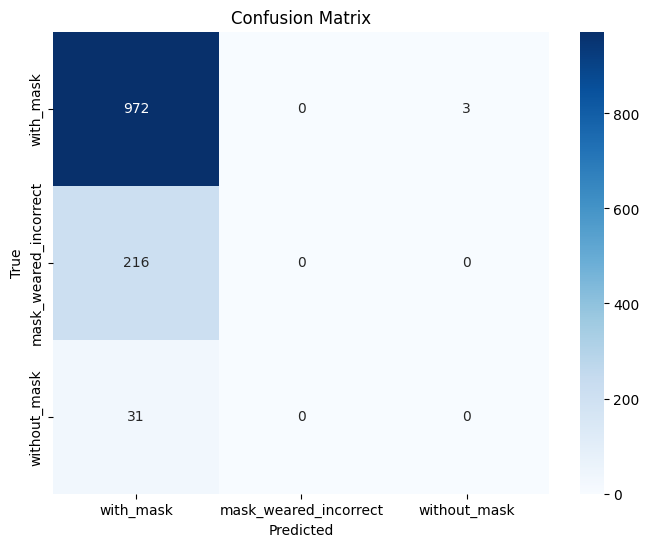

In [53]:
# Manual Model

accuracy_metric_evaluation(test_true_labels_manual, test_pred_labels_manual, class_names=target_items)

                       precision    recall  f1-score   support

            with_mask       0.92      0.98      0.95       975
mask_weared_incorrect       0.86      0.75      0.80       216
         without_mask       0.00      0.00      0.00        31

             accuracy                           0.91      1222
            macro avg       0.60      0.58      0.58      1222
         weighted avg       0.89      0.91      0.90      1222



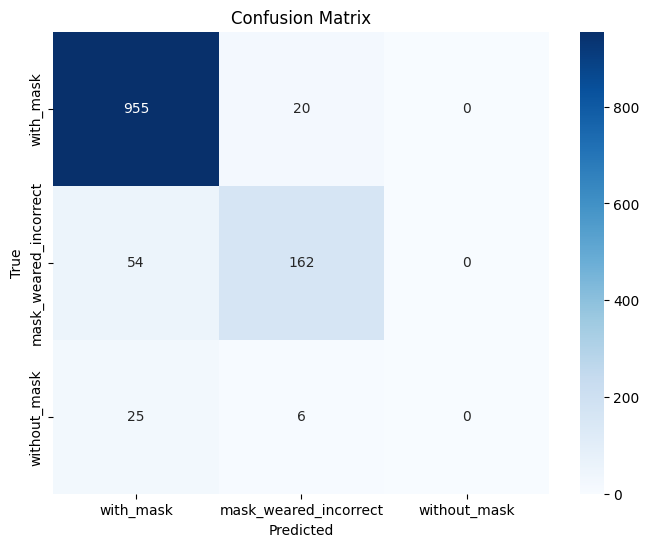

In [54]:
# torchvision

accuracy_metric_evaluation(test_true_labels_torchvision, test_pred_labels_torchvision, class_names=target_items)